In [1]:
%matplotlib inline
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_data(date='20180323',runs='all'):

    #Load Data
    cwd = os.getcwd()
    run_dir = cwd+'/'+date+'/'
    data={}
    if runs == 'all':
           dirs = glob(run_dir+'run*')
    else:
           dirs = glob(run_dir+runs)
    data_calib_found=0
    no_data=[]
    for r in dirs:
        run_num = r.split('run_')[-1]
        data['run_'+str(run_num)]={}
        sim_info=pd.read_csv(r+'/sim_info.csv')    
        cmd_list=pd.read_csv(r+'/cmd_list.csv')
        imu_file=glob(r+'/imu_*')
        try:
            imu_data=pd.read_csv(imu_file[0],parse_dates=True,infer_datetime_format=True,index_col='time')
            data['run_'+str(run_num)]['imu_data']=imu_data
        except:
            #print('cannot find imu data for run_'+str(run_num)+' on '+date)
            continue
        data['run_'+str(run_num)]['sim_info']=sim_info
        data['run_'+str(run_num)]['cmd_list']=cmd_list
        vid_file=data['run_'+str(run_num)]['sim_info'].filename[0].split('100GOPRO/')[-1]
        vid_num=data['run_'+str(run_num)]['sim_info'].filename[0].split('100GOPRO/')[-1].split('.MP4')[0]
        try:
            data['run_'+str(run_num)]['laser_data']=pd.read_csv(run_dir+vid_num+'.csv',parse_dates=True,infer_datetime_format=True)
        except:
            #print('cannot find '+vid_num+'.csv for run_'+str(run_num)+' on '+date)
            no_data.append('run_'+run_num)
        if 'calibrate' in sim_info.sim_file[0]:
            data_calib=data['run_'+str(run_num)]['laser_data']
            data_calib_found=1

    #Process calibration data to calculate degrees per pixel to use for other runs (med_dpp)
    if data_calib_found == 0:
        print('no calibration file found for '+date)
    else:
        time=data_calib.time_elapsed.to_frame()/1e3

        #1 second smooth to remove stair step
        rm=data_calib.laser_cen_x.to_frame().rolling(120,center=True).mean()

        #plt.figure(1)
        #plt.plot(time,data.laser_cen_x,'x',color='black')
        #plt.plot(time,rm,'-+',color='blue')

        dif_pos=rm.diff().values
        dif_time=time.diff().values

        #angular rate in GOPRO pixels per second
        deriv=dif_pos/(dif_time)

        #PTU angular rate in degrees per second
        ptu_rate=-23.14285/60/60

        #degrees per pixel
        dpp=ptu_rate/deriv
        med_dpp=np.nanmedian(dpp)

        xpos=data_calib.laser_cen_x.to_frame()*med_dpp
        time=data_calib.time_elapsed.to_frame()/1e3

    for r in sorted(data):     
        if r not in no_data: 
            
            #just assume 0.6 degrees across entire 1280 pixels
            med_dpp=0.6/1280.0
            
            try:
                #Extract time_laser and time_imu_sync to plot laser and imu data together
                data[r]['time_laser']=data[r]['laser_data'].time_elapsed.to_frame()/1e3
                data[r]['imu_data']['time']=data[r]['imu_data'].index.to_datetime()-data[r]['imu_data'].index[0]
                data[r]['imu_data']['time']=data[r]['imu_data']['time'].astype('timedelta64[ms]')/1000.0
                #Add in delay for imu_data recording ~2.2seconds
                data[r]['time_imu_sync']=data[r]['imu_data']['time']+2.2   

                #Laser data in gopro pixels
                data[r]['xpos_gopro']=data[r]['laser_data'].laser_cen_x.to_frame()

                #Convert GOPRO pixels to degrees ->xpos_deg
                data[r]['xpos_deg']=data[r]['laser_data'].laser_cen_x.to_frame()*med_dpp

                #Convert degrees to GLO pixels (1 GLO pixel = 0.0025 degrees)
                glo_dpp=0.53/211   #sun disc 0.53deg per 211 glo pixels
                data[r]['xpos_glo']=data[r]['xpos_deg']/glo_dpp

                #Laser data in degrees/second
                data[r]['deg_per_sec'] = data[r]['xpos_deg'].diff().values/data[r]['time_laser'].diff().values

                data[r]['std_xpos_120']=data[r]['xpos_glo'].rolling(120,center=True).std()
                #20 frames at 120FPS ~ 1 stacked frame at 6Hz
                data[r]['std_xpos_020']=data[r]['xpos_glo'].rolling(20,center=True).std()
                
                data[r]['pix_smear']=data[r]['xpos_glo'].diff().values/data[r]['time_laser'].diff().values/1e3
                data[r]['pix_smear_120']=pd.DataFrame(data[r]['pix_smear']).rolling(120,center=True).std()


            except:
                print('could not extract data '+date +' '+ r)
                continue
    return data

# 20180321 sun position cloud stacked frames
## PTU stack mounted on swivel chair bracket, moved randomly at slow speeds

/home/ramble/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


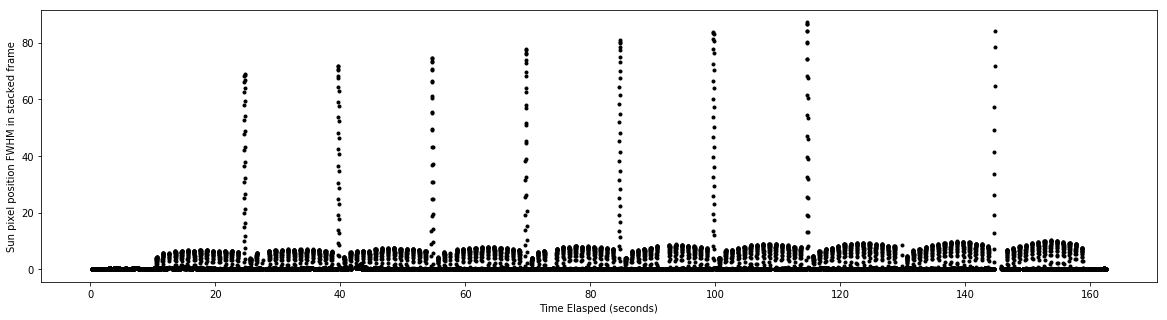

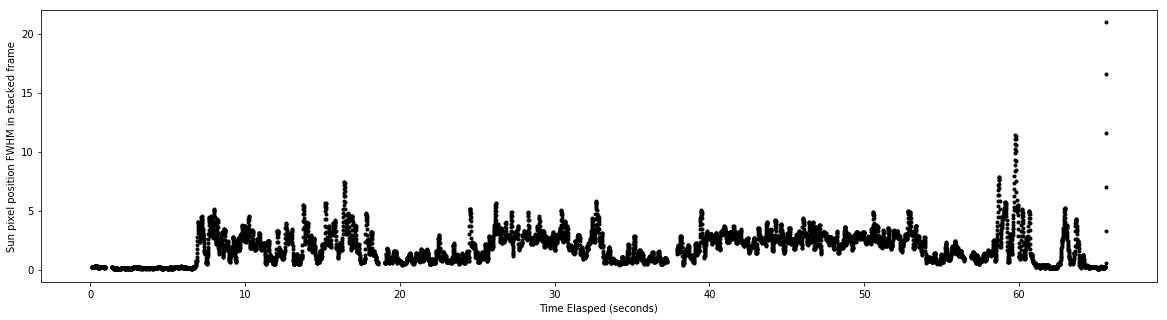

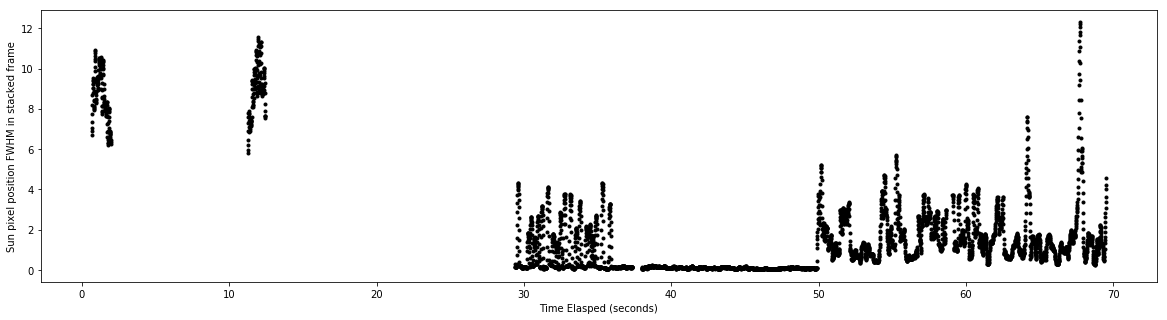

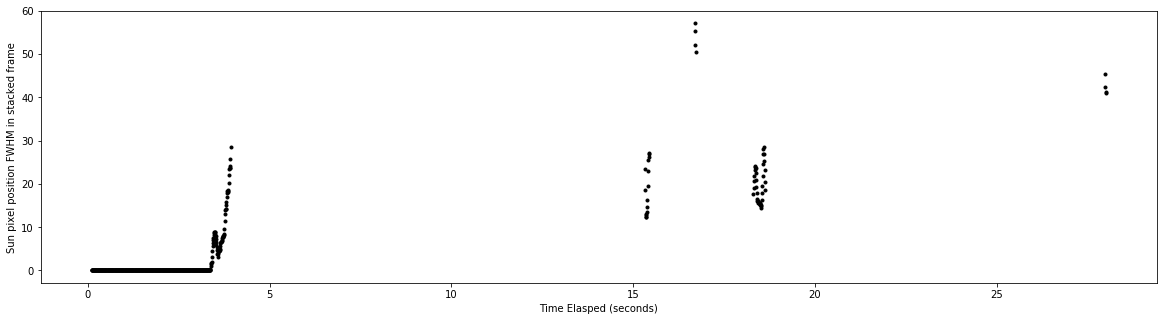

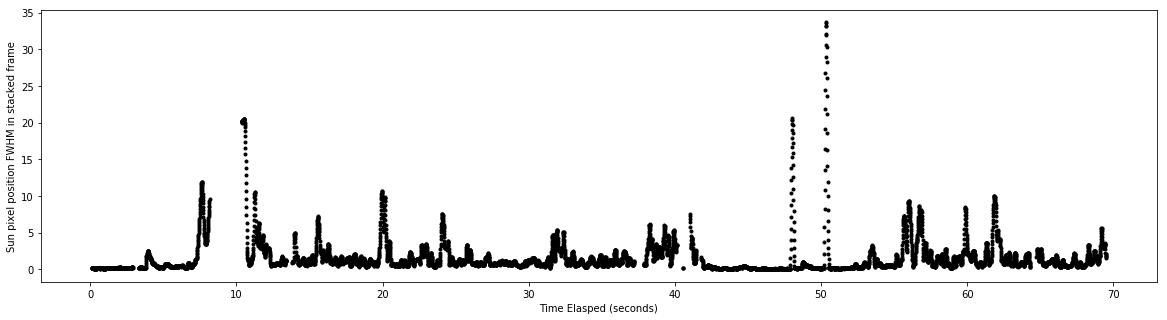

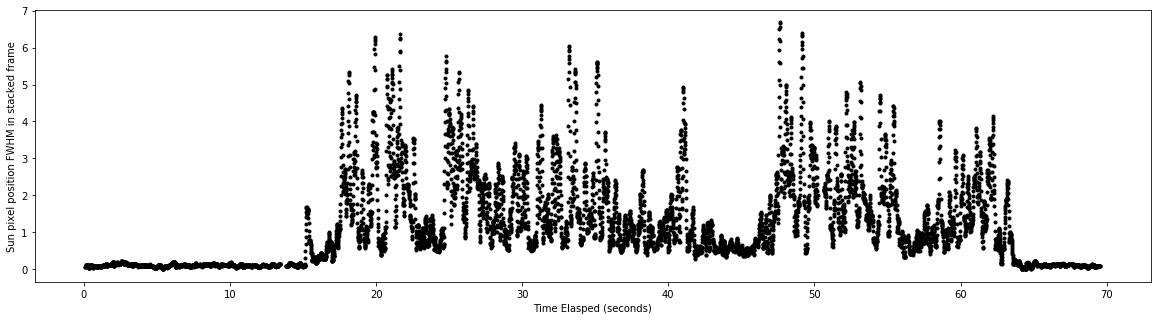

In [3]:
#Pick date to plot
data = load_data(date='20180321',runs='all')

#Plot sun position cloud per stacked frame
for r in sorted(data):
    try:   
        plt.figure(figsize=(20,5))
        plt.plot(data[r]['time_laser'],
                 data[r]['std_xpos_020'],
                 color='black',
                 marker='.',
                 linestyle="None",
                 label='kp='+str(data[r]['sim_info'].d48_kp[0])+' '+
                       'ks='+str(data[r]['sim_info'].d48_ks[0])+' '+
                       'ka='+str(data[r]['sim_info'].d48_ka[0])+' '+
                       'vd='+str(data[r]['sim_info'].d48_vd[0])+' '+
                       'pd='+str(data[r]['sim_info'].d48_pd[0])+' ')
        plt.ylabel('Sun pixel position FWHM in stacked frame')
        plt.xlabel('Time Elasped (seconds)')
        plt.title("Glo sun position cloud width per stacked frame\n"+date+' '+r)
        plt.legend(loc='upper left')
        plt.ylim((0,10))
    except:
        continue

# 20180322 sun position cloud stacked frames
## PTU stack mounted on swivel chair bracket, moved randomly at slow speeds

no calibration file found for 20180322


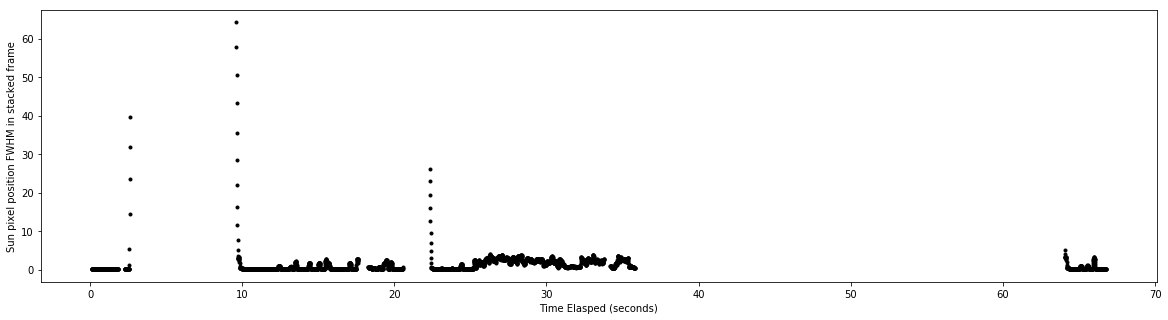

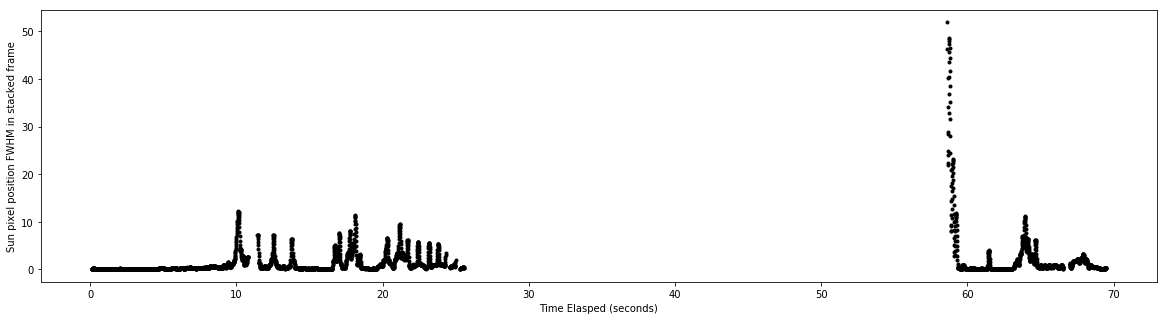

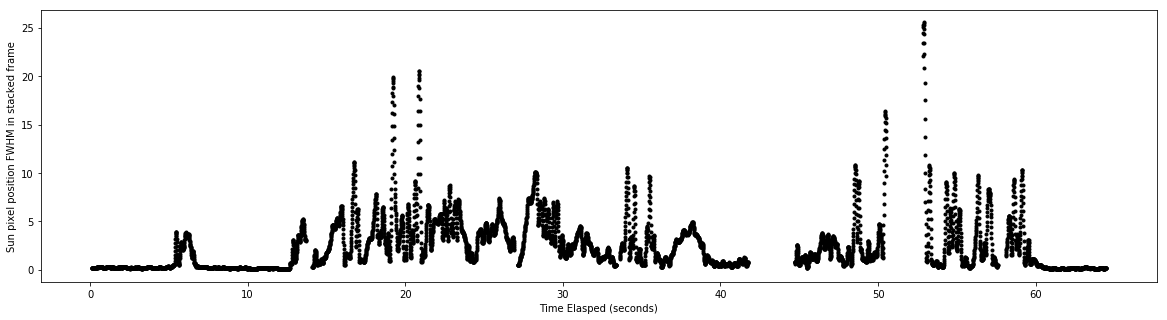

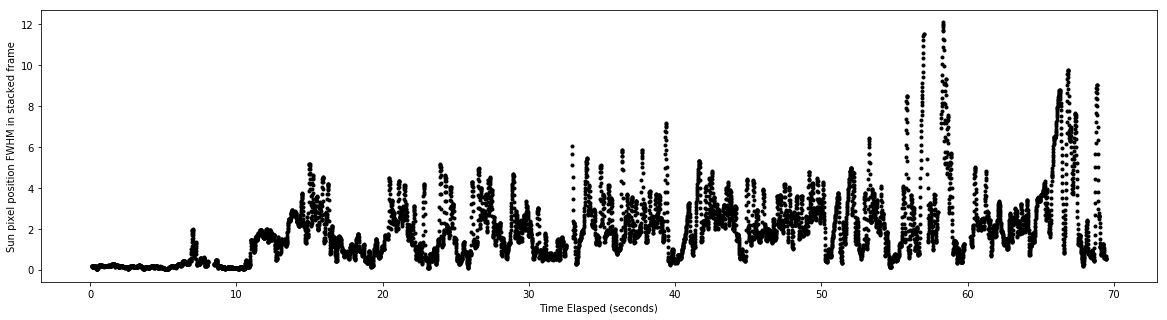

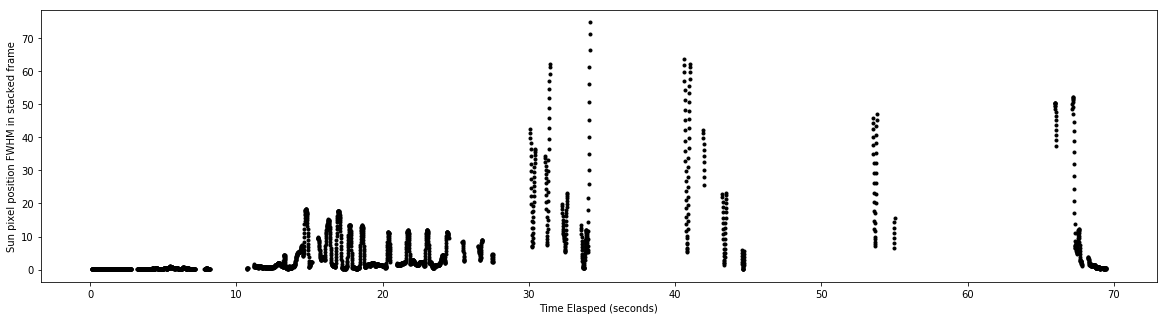

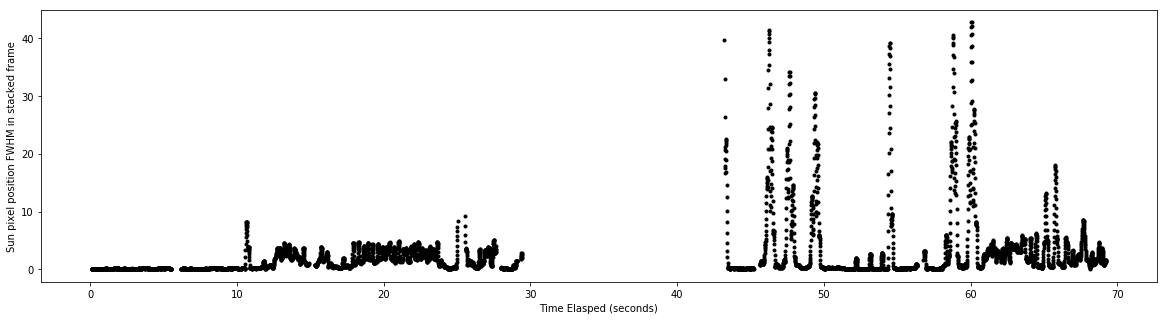

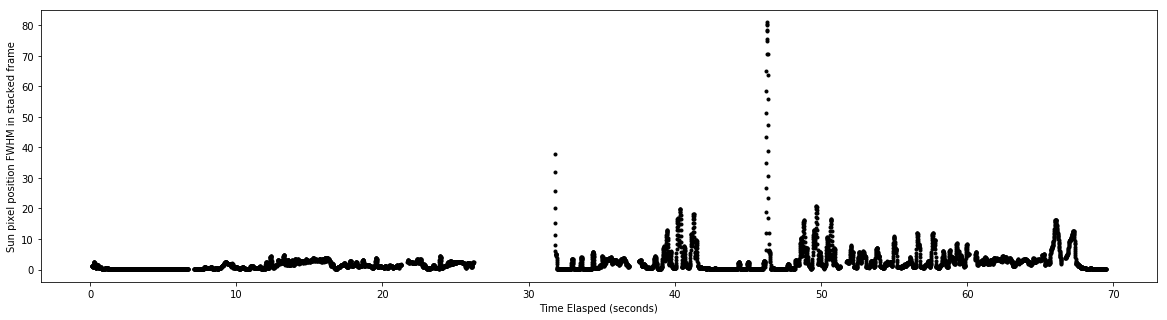

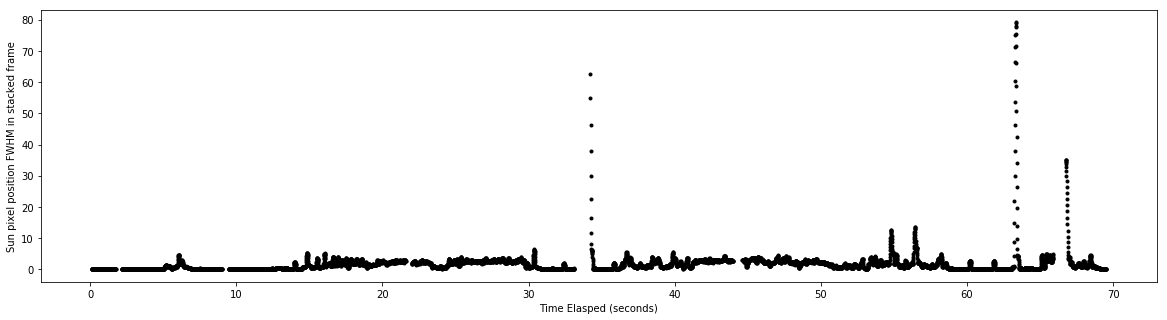

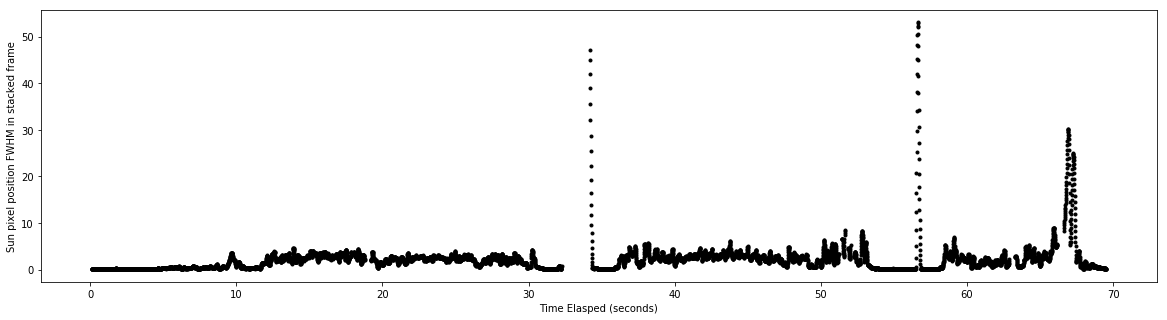

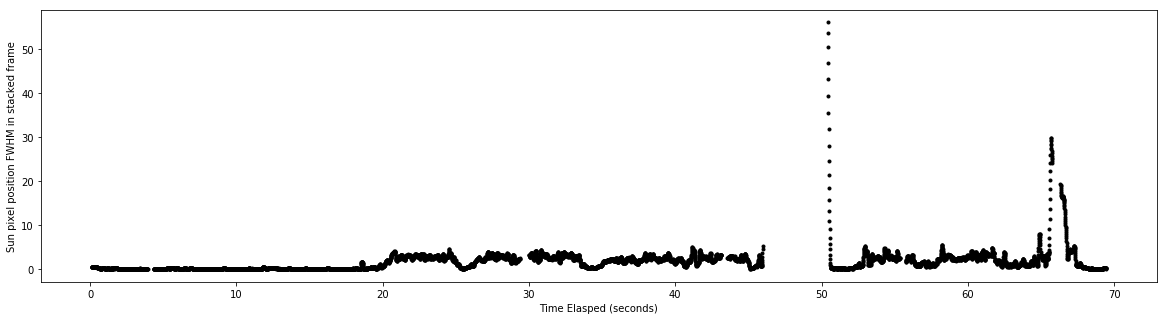

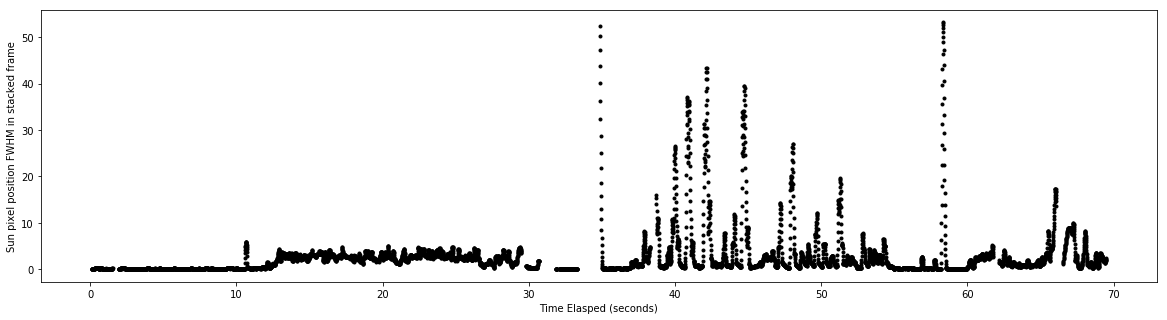

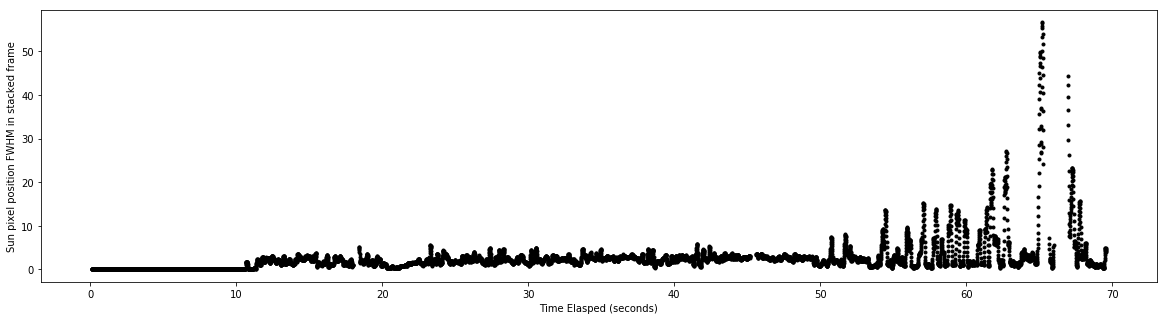

In [4]:
#Pick date to plot
data = load_data(date='20180322',runs='all')

#Plot sun position cloud per stacked frame
for r in sorted(data):
    try:   
        plt.figure(figsize=(20,5))
        plt.plot(data[r]['time_laser'],
                 data[r]['std_xpos_020'],
                 color='black',
                 marker='.',
                 linestyle="None",
                 label='kp='+str(data[r]['sim_info'].d48_kp[0])+' '+
                       'ks='+str(data[r]['sim_info'].d48_ks[0])+' '+
                       'ka='+str(data[r]['sim_info'].d48_ka[0])+' '+
                       'vd='+str(data[r]['sim_info'].d48_vd[0])+' '+
                       'pd='+str(data[r]['sim_info'].d48_pd[0])+' ')
        plt.ylabel('Sun pixel position FWHM in stacked frame')
        plt.xlabel('Time Elasped (seconds)')
        plt.title("Glo sun position cloud width per stacked frame\n"+date+' '+r)
        plt.legend(loc='upper left')
        plt.ylim((0,10))
    except:
        continue

# 20180323 sun position cloud stacked frames
## PTU stack mounted on floor, multiple 10 second offset commands at varying speeds

/home/ramble/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


could not extract data 20180323 run_3
could not extract data 20180323 run_4


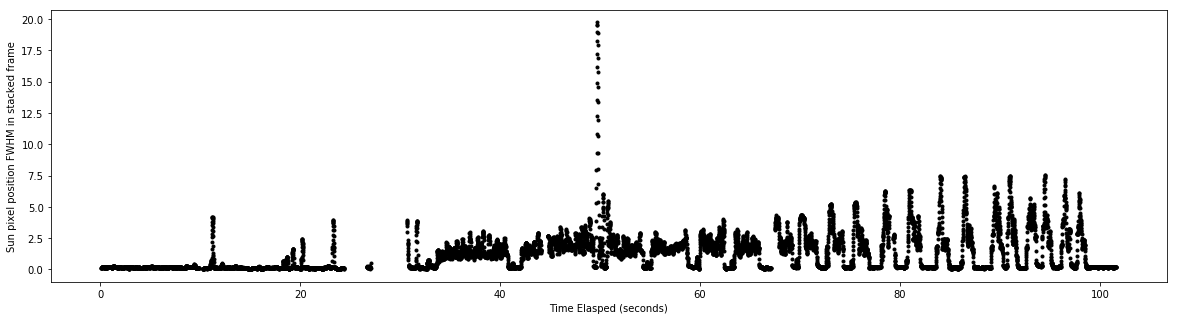

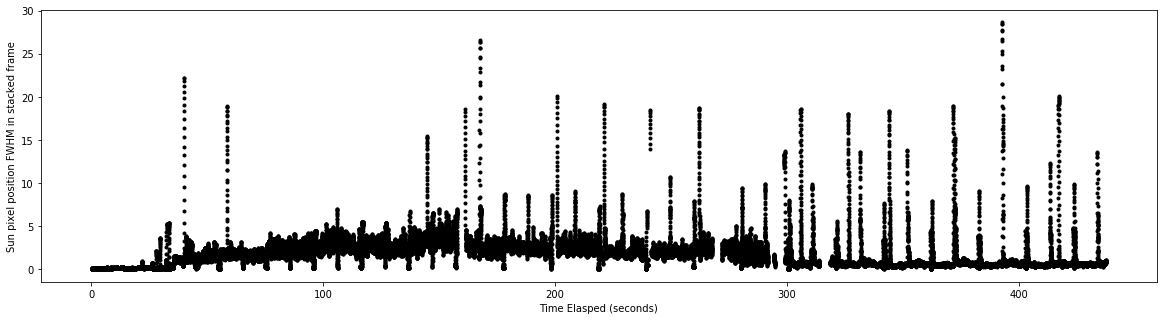

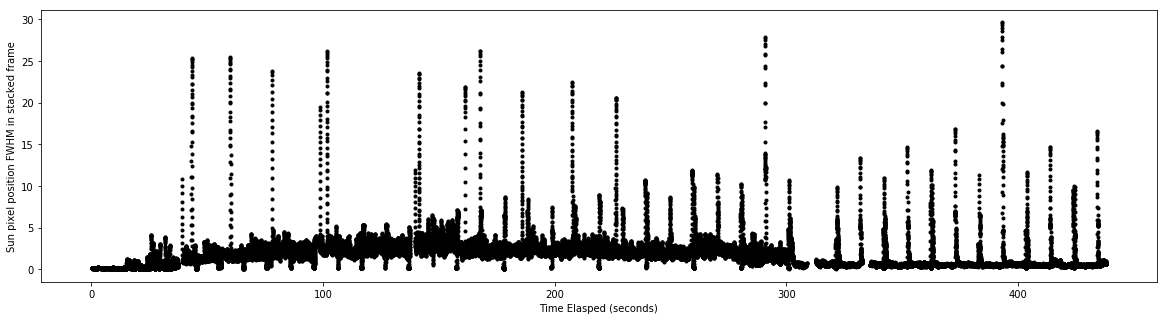

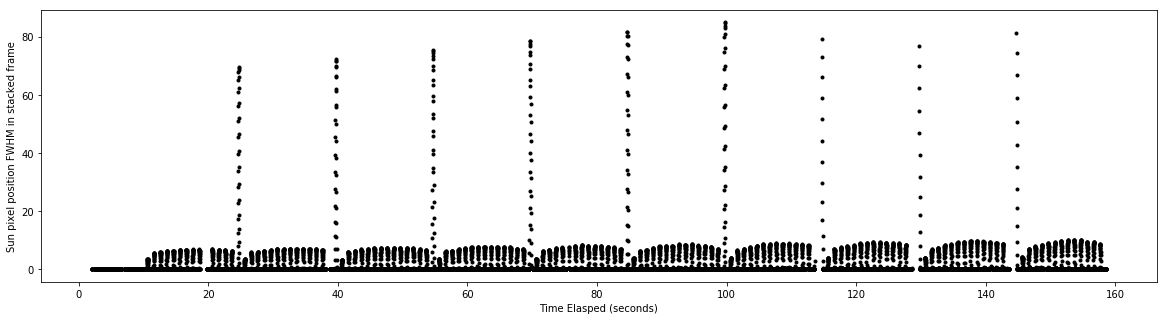

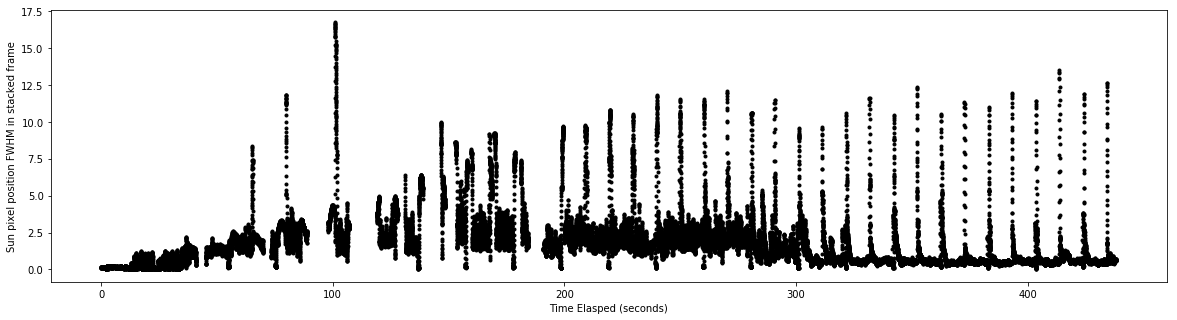

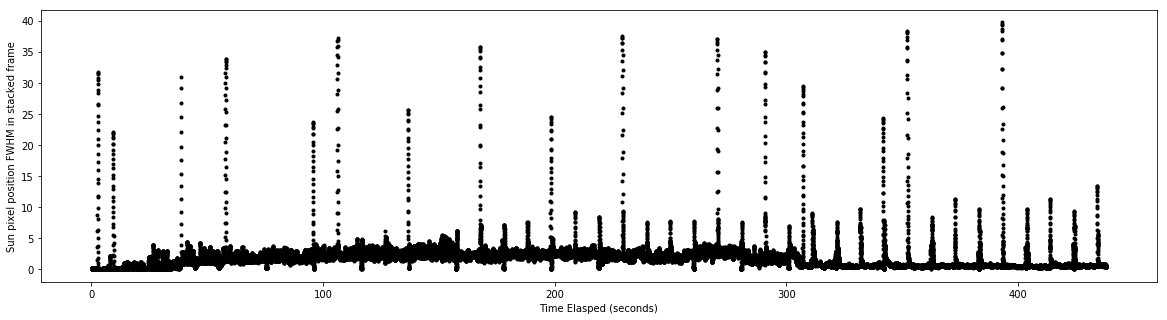

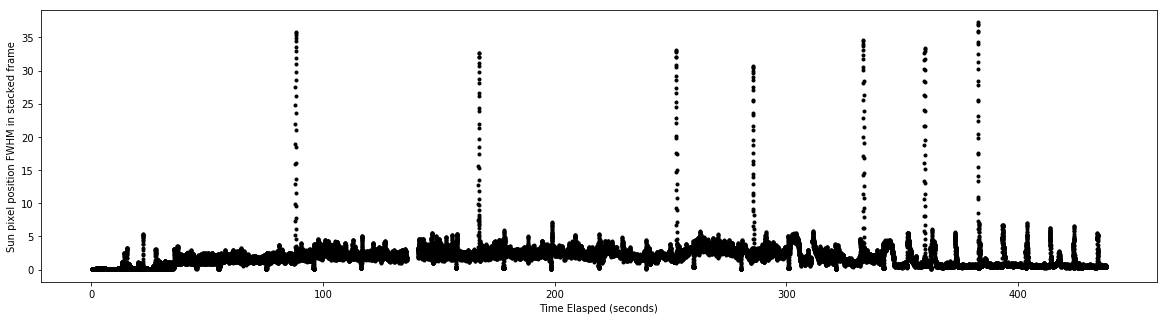

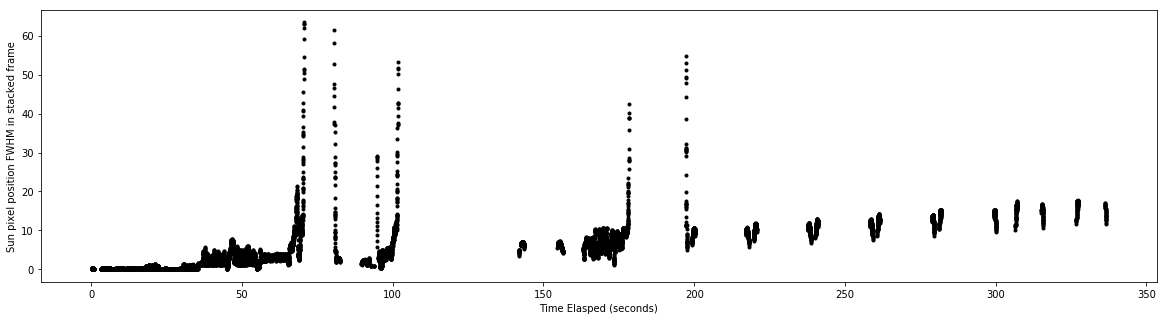

In [7]:
#Pick date to plot
data = load_data(date='20180323',runs='all')

#Plot sun position cloud per stacked frame
for r in sorted(data):
    try:   
        plt.figure(figsize=(20,5))
        plt.plot(data[r]['time_laser'],
                 data[r]['std_xpos_020'],
                 color='black',
                 marker='.',
                 linestyle="None",
                 label='kp='+str(data[r]['sim_info'].d48_kp[0])+' '+
                       'ks='+str(data[r]['sim_info'].d48_ks[0])+' '+
                       'ka='+str(data[r]['sim_info'].d48_ka[0])+' '+
                       'vd='+str(data[r]['sim_info'].d48_vd[0])+' '+
                       'pd='+str(data[r]['sim_info'].d48_pd[0])+' ')
        plt.ylabel('Sun pixel position FWHM in stacked frame')
        plt.xlabel('Time Elasped (seconds)')
        plt.title("Glo sun position cloud width per stacked frame\n"+date+' '+r)
        plt.legend(loc='upper left')
        plt.ylim((0,10))
    except:
        continue